# Read Dataset and import libraries

In [6]:
! git clone https://github.com/Ironarrow98/Zhang_Chenxi_BS6207_Final

fatal: destination path 'Zhang_Chenxi_BS6207_Final' already exists and is not an empty directory.


In [7]:
! pip install sparse

In [8]:
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import itertools
import numpy as np
import random
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D,Flatten,Dense, Dropout, BatchNormalization, Add, AveragePooling3D, Activation, GaussianNoise, Lambda
from tensorflow.keras import optimizers, losses, regularizers
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.initializers import glorot_normal
from tensorflow.keras.utils import plot_model, Sequence
from tensorflow.keras.activations import relu
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler
from imblearn.under_sampling import AllKNN
from imblearn.combine import SMOTEENN
from IPython.display import SVG
from sklearn.metrics import confusion_matrix, matthews_corrcoef
from tqdm import tqdm, trange
import tensorflow as tf
import os
from sparse import COO
import sparse

In [11]:
# Reads a up to spec pdb file and return a tuple of the
# atoms' x, y, z and atomtype
def read_pdb(filename):
  with open(filename, 'r') as file:
    strline_L = file.readlines()
  atom_list = []
  for strline in strline_L:
    # removes all whitespace at the start and end, including spaces, tabs, newlines and carriage returns
    stripped_line = strline.strip()

    line_length = len(stripped_line)
    # print("Line length:{}".format(line_length))
    if line_length < 78:
      print("ERROR: line length is different. Expected>=78, current={}".format(line_length))
        
    atom_list.append((
        stripped_line[30:38].strip(),
        stripped_line[38:46].strip(),
        stripped_line[46:54].strip(),
        'h' if stripped_line[76:78].strip() == 'C' else 'p'
        ))
        
  return np.array(atom_list, order='F')

In [12]:
# Reads the test pdb file and return a tuple of the
# atoms' x, y, z and atomtype
def read_test_pdb(filename):
  with open(filename, 'r') as file:
    strline_L = file.readlines()
  atom_list = []
  for strline in strline_L:
    # removes all whitespace at the start and end, including spaces, tabs, newlines and carriage returns
    stripped_line = strline.strip()
    tokens = stripped_line.split("\t")
        
    atom_list.append((
        tokens[0],
        tokens[1],
        tokens[2],
        tokens[3]
        ))

  return np.array(atom_list, order='F')

In [13]:
raw_training_data = {
    'pro': [],
    'lig': []
}
for i in trange(3000):
  raw_training_data['pro'].append(
      read_pdb('Zhang_Chenxi_BS6207_Final/training_data/{:04d}_pro_cg.pdb'.format(i + 1)))
  raw_training_data['lig'].append(
      read_pdb("Zhang_Chenxi_BS6207_Final/training_data/{:04d}_lig_cg.pdb".format(i + 1)))

n = int(len(raw_training_data['pro']) * 0.77)
raw_training_train_data = {
    'pro': raw_training_data['pro'][:n],
    'lig': raw_training_data['lig'][:n]
}
raw_training_test_data = {
    'pro': raw_training_data['pro'][n:],
    'lig': raw_training_data['lig'][n:]
}

testing_data = {
    'pro': [],
    'lig': []
}

for i in range(1, 825):
  testing_data['pro'].append(
      # Load your own file path for the testing data, same as training_data
      read_test_pdb('Zhang_Chenxi_BS6207_Final/testing_data_release/testing_data/{:04d}_pro_cg.pdb'.format(i)))
  testing_data['lig'].append(
      # Load your own file path for the testing data, same as training_data
      read_test_pdb('Zhang_Chenxi_BS6207_Final/testing_data_release/testing_data/{:04d}_lig_cg.pdb'.format(i)))

100%|██████████| 3000/3000 [00:09<00:00, 322.04it/s]


# Data Pre-processing

In [37]:
# Returns a sparse matrix representation of the voxel
def voxelize(pdb_inputs, max_dist = 20, grid_resolution = 4):
  def featurize(atom_type):
    feat = [0, 128]
    # Change to ligand
    if atom_type[1] == 'l':
      feat[0] = 1
    # change to polar
    if atom_type[0] == 'p':
      feat[1] = 256
    return feat
    
  max_dist = float(max_dist)
  grid_resolution = float(grid_resolution)
  box_size = np.ceil(2 * max_dist / grid_resolution + 1)

  # merge protein and ligand
  pro_atomtypes = pdb_inputs[0]
  lig_atomtypes = pdb_inputs[1]
  pro_atomtype = np.c_[pro_atomtypes, np.full(pro_atomtypes.shape[0], 'p')]
  lig_atomtype = np.c_[lig_atomtypes, np.full(lig_atomtypes.shape[0], 'l')]
  all_atoms = np.r_[pro_atomtype, lig_atomtype]

  # center all atoms around the center of the protein
  cord_map = all_atoms[:, :3].astype(np.float)
  cord_map = cord_map - np.mean(lig_atomtype[:, :3].astype(np.float), axis = 0)

  # add feature list to identify the atom h/p and pro/lig
  feature_list = np.asarray([featurize(atom_type) for atom_type in all_atoms[:,-2:]])  
  atom_map = np.c_[cord_map, feature_list]

  # move all atoms to the nearest grid point
  atom_map = np.c_[cord_map, feature_list]
  atom_map[:, :3] = (atom_map[:, :3] + max_dist) / grid_resolution
  atom_map[:, :3] = atom_map[:, :3].round()
  atom_map = atom_map.astype(int)

  # remove atoms outside the box
  in_box = ((atom_map[:, :3] >= 0) & (atom_map[:,:3] < box_size)).all(axis = 1)
  atom_map = atom_map[in_box]

  # transpose the matrix
  features_list = np.squeeze(atom_map[:,-1:])
  atom_map = atom_map[:,:4].T
    
  # create the sparse matrix
  result = COO(atom_map, features_list, 
               shape = (int(box_size), 
                        int(box_size), 
                        int(box_size), 
                        2))
  result.sum()
  result = result.reshape((1, int(box_size), int(box_size), int(box_size), 2))
    
  return result

In [38]:
# Returns a tuple containg the training data and corresponding labels
# ratio specifies the number of negative training examples generated
# per positive training example
def generate_training_data(raw_data, pos_ratio=1, neg_ratio=1, max_dist=20, grid_resolution=4, quiet=False):
  n = len(raw_data['pro'])
  all_x = []
  all_y = []
  pro_name = []
  lig_name = []
  for i in tqdm(range(n), disable = quiet):
    for _ in range(pos_ratio):
      grid = voxelize((raw_data['pro'][i], raw_data['lig'][i]), max_dist, grid_resolution)
      all_x.append(grid)
      all_y.append([float(1)])
      pro_name.append(i)
      lig_name.append(i)
    for _ in range(neg_ratio):
      name = random.choice(list(range(i)) + list(range(i + 1, n)))
      grid = voxelize((raw_data['pro'][i], raw_data['lig'][name]), max_dist, grid_resolution)
      all_x.append(grid)
      all_y.append([float(0)])
      pro_name.append(i)
      lig_name.append(name)
  return sparse.concatenate(all_x), np.asarray(all_y), pro_name, lig_name

# CNN Model

In [16]:
def make_CNN(input_shape):
  inputs = Input(shape = input_shape)
  x = inputs
  x = Conv3D(filters = 16,
             kernel_size = 3,
             padding = 'valid',
             kernel_initializer = 'he_normal',
             activation="relu")(x)     
  x = BatchNormalization()(x)

  x = Conv3D(filters = 32,
             kernel_size = 3,
             padding = 'valid',
             kernel_initializer = 'he_normal',
             activation = "relu")(x)     
  x = BatchNormalization()(x)

  x = Conv3D(filters = 64,
             kernel_size = 3,
             padding = 'valid',
             kernel_initializer = 'he_normal',
             activation = "relu")(x)     
  x = BatchNormalization()(x)

  x = Conv3D(filters = 128,
             kernel_size = 3,
             padding = 'valid',
             kernel_initializer = 'he_normal',
             activation = "relu")(x)     
  x = BatchNormalization()(x)

  x = AveragePooling3D()(x)
  x = Flatten()(x)
  x = Dense(128, activation = 'relu', kernel_initializer = 'he_normal')(x)
  x = Dropout(0.5)(x)
  outputs = Dense(2, activation = 'sigmoid', kernel_initializer = 'he_normal')(x)

  return Model(inputs = inputs, outputs = outputs)

In [17]:
model = make_CNN(input_shape = (21, 21, 21, 2))
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 21, 21, 21, 2)]   0         
                                                                 
 conv3d (Conv3D)             (None, 19, 19, 19, 16)    880       
                                                                 
 batch_normalization (BatchN  (None, 19, 19, 19, 16)   64        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 19, 19, 19, 16)    0         
                                                                 
 conv3d_1 (Conv3D)           (None, 17, 17, 17, 32)    13856     
                                                                 
 batch_normalization_1 (Batc  (None, 17, 17, 17, 32)   128       
 hNormalization)                                             

In [18]:
train_X, train_y, train_pro, train_lig = generate_training_data(raw_training_test_data, pos_ratio=10, neg_ratio=10, max_dist=40, grid_resolution=4)
val_X, val_y, val_pro, val_lig = generate_training_data(raw_training_test_data, pos_ratio=10, neg_ratio=10, max_dist=40, grid_resolution=4)
test_X, test_y, test_pro, test_lig = generate_training_data(testing_data, pos_ratio=10, neg_ratio=10, max_dist=40, grid_resolution=4)

train_X = train_X.todense()
val_X = val_X.todense()
test_X = test_X.todense()

100%|██████████| 824/824 [01:20<00:00, 10.19it/s]


In [19]:
# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
train_y = onehot_encoder.fit_transform(train_y)
val_y = onehot_encoder.fit_transform(val_y)
test_y = onehot_encoder.fit_transform(test_y)

In [20]:
model.compile(
    loss='binary_crossentropy',
    metrics=['acc'],
    optimizer='Adam'
)

# create a callback that will save the best model while training
save_best_model = ModelCheckpoint('best_model1.h5', monitor='val_acc', mode='max', save_best_only = True, verbose = 2)

history = model.fit(train_X, train_y,
                    batch_size = 64,
                    epochs = 20,
                    validation_data = (val_X, val_y),
                    shuffle = True,
                    callbacks = [save_best_model])

Epoch 1/20
216/216 [==============================] - ETA: 0s - loss: 0.2941 - acc: 0.9194
Epoch 00001: val_acc improved from -inf to 0.93449, saving model to best_model1.h5
216/216 [==============================] - 286s 1s/step - loss: 0.2941 - acc: 0.9194 - val_loss: 0.1664 - val_acc: 0.9345
Epoch 2/20
216/216 [==============================] - ETA: 0s - loss: 0.1528 - acc: 0.9429
Epoch 00002: val_acc improved from 0.93449 to 0.94507, saving model to best_model1.h5
216/216 [==============================] - 288s 1s/step - loss: 0.1528 - acc: 0.9429 - val_loss: 0.1735 - val_acc: 0.9451
Epoch 3/20
216/216 [==============================] - ETA: 0s - loss: 0.1013 - acc: 0.9608
Epoch 00003: val_acc improved from 0.94507 to 0.97652, saving model to best_model1.h5
216/216 [==============================] - 289s 1s/step - loss: 0.1013 - acc: 0.9608 - val_loss: 0.0679 - val_acc: 0.9765
Epoch 4/20
216/216 [==============================] - ETA: 0s - loss: 0.0485 - acc: 0.9842
Epoch 00004: va

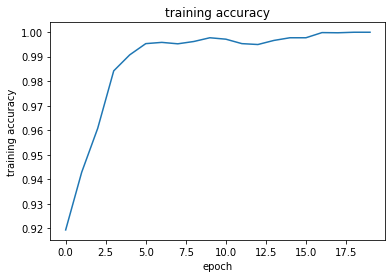

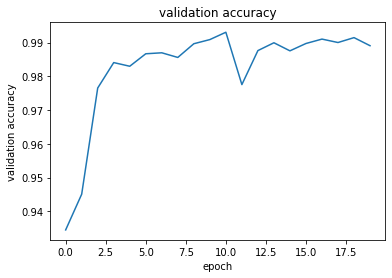

In [21]:
# Plot training accuracy
plt.plot(history.history['acc'])
plt.title('training accuracy')
plt.ylabel('training accuracy')
plt.xlabel('epoch')
#plt.legend(['lr = 0.01', 'lr = 0.001', 'lr = 0.0001'], loc='upper left')
plt.show()

# Plot validation accuracy
plt.plot(history.history['val_acc'])
plt.title('validation accuracy')
plt.ylabel('validation accuracy')
plt.xlabel('epoch')
#plt.legend(['lr = 0.01', 'lr = 0.001', 'lr = 0.0001'], loc='upper left')
plt.show()

# Create Submission File

In [22]:
best_model = load_model("best_model1.h5")
y_pred = best_model.predict(test_X)
y_pred

array([[1.0000000e+00, 4.3393886e-26],
       [1.0000000e+00, 4.3393886e-26],
       [1.0000000e+00, 4.3393886e-26],
       ...,
       [1.0000000e+00, 1.1959725e-36],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00]], dtype=float32)

In [30]:
prob = pd.DataFrame(data=y_pred, columns = ["0", "1"], index = test_lig)
prob['protein'] = test_pro
prob['ligand'] = test_lig
prob

,0,1,protein,ligand
0,1.0,0.0,0,0
0,1.0,0.0,0,0
0,1.0,0.0,0,0
0,1.0,0.0,0,0
0,1.0,0.0,0,0
...,...,...,...,...
182,1.0,0.0,823,182
165,1.0,0.0,823,165
359,1.0,0.0,823,359
236,1.0,0.0,823,236


In [31]:
top10_prediction = []
for i in range(824):
  tmp = prob[prob['protein'] == i]
  top10 = tmp.sort_values(by = ['1'], ascending = False).head(10)
  top10_prediction.append(top10['ligand'].tolist())
top10_prediction

[[0, 0, 106, 464, 39, 560, 348, 587, 306, 706],
 [1, 1, 647, 132, 726, 402, 686, 579, 179, 811],
 [2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
 [3, 3, 344, 31, 19, 619, 35, 673, 477, 562],
 [4, 4, 804, 607, 338, 280, 298, 99, 695, 305],
 [5, 5, 588, 603, 491, 119, 816, 502, 620, 406],
 [410, 6, 6, 354, 304, 766, 98, 116, 566, 532],
 [7, 7, 807, 284, 179, 347, 330, 635, 651, 534],
 [563, 8, 8, 20, 767, 137, 497, 434, 291, 284],
 [9, 9, 422, 586, 77, 820, 169, 744, 624, 710],
 [10, 10, 190, 723, 571, 392, 650, 82, 659, 765],
 [11, 11, 127, 135, 111, 578, 810, 659, 584, 51],
 [12, 12, 309, 438, 148, 97, 417, 760, 194, 644],
 [13, 13, 207, 110, 592, 101, 403, 501, 298, 559],
 [14, 14, 14, 14, 14, 14, 14, 14, 14, 14],
 [15, 15, 706, 783, 35, 210, 756, 373, 703, 105],
 [16, 16, 815, 671, 541, 54, 787, 760, 730, 448],
 [17, 17, 362, 680, 199, 628, 45, 817, 425, 412],
 [18, 18, 472, 485, 0, 497, 488, 673, 125, 296],
 [19, 19, 430, 554, 793, 262, 798, 784, 148, 611],
 [20, 20, 748, 303, 76, 183, 655, 297, 8

In [35]:
test_prediction = pd.DataFrame(data=top10_prediction, columns = ['lig1_id', 'lig2_id', 'lig3_id', 
                                                       'lig4_id', 'lig5_id', 'lig6_id',
                                                       'lig7_id', 'lig8_id', 'lig9_id',	
                                                       'lig10_id'])
test_prediction.insert(0, 'pro_id', range(824))
test_prediction += 1
test_prediction

,pro_id,lig1_id,lig2_id,lig3_id,lig4_id,lig5_id,lig6_id,lig7_id,lig8_id,lig9_id,lig10_id
0,1,1,1,107,465,40,561,349,588,307,707
1,2,2,2,648,133,727,403,687,580,180,812
2,3,3,3,3,3,3,3,3,3,3,3
3,4,4,4,345,32,20,620,36,674,478,563
4,5,5,5,805,608,339,281,299,100,696,306
...,...,...,...,...,...,...,...,...,...,...,...
819,820,820,820,181,187,549,311,26,313,654,241
820,821,821,821,316,247,602,428,196,565,90,767
821,822,822,822,60,810,362,579,196,594,796,445
822,823,823,823,667,115,518,100,488,383,407,737


In [36]:
test_prediction.to_csv('test_predictions.txt', index = None, sep = ' ')